# MIT-BIH Arrhythmia Database Exploration

This notebook provides interactive exploration of the MIT-BIH Arrhythmia Database.


In [1]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from load_ecg_data import load_ecg_record, visualize_ecg, get_annotation_statistics, list_available_records

# Set matplotlib style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline


## 1. List Available Records


In [2]:
records = list_available_records()
print(f"\nTotal records: {len(records)}")



Available records in data/mitdb:
 1. 100   2. 101   3. 102   4. 103   5. 104   6. 105   7. 106   8. 107  
 9. 108  10. 109  11. 111  12. 112  13. 113  14. 114  15. 115  16. 116  
17. 117  18. 118  19. 119  20. 121  21. 122  22. 123  23. 124  24. 200  
25. 201  26. 202  27. 203  28. 205  29. 207  30. 208  31. 209  32. 210  
33. 212  34. 213  35. 214  36. 215  37. 217  38. 219  39. 220  40. 221  
41. 222  42. 223  43. 228  44. 230  45. 231  46. 232  47. 233  48. 234  


Total records: 48


## 2. Load and Examine a Single Record


In [3]:
# Choose a record to examine
record_name = '100'

# Load the record
record, annotation = load_ecg_record(record_name)

print(f"Record: {record_name}")
print(f"Sampling frequency: {record.fs} Hz")
print(f"Duration: {len(record.p_signal) / record.fs / 60:.2f} minutes")
print(f"Number of leads: {len(record.sig_name)}")
print(f"Lead names: {record.sig_name}")
print(f"Units: {record.units}")
print(f"Number of annotations: {len(annotation.sample)}")


Record: 100
Sampling frequency: 360 Hz
Duration: 30.09 minutes
Number of leads: 2
Lead names: ['MLII', 'V5']
Units: ['mV', 'mV']
Number of annotations: 2274


## 3. Visualize ECG Signal


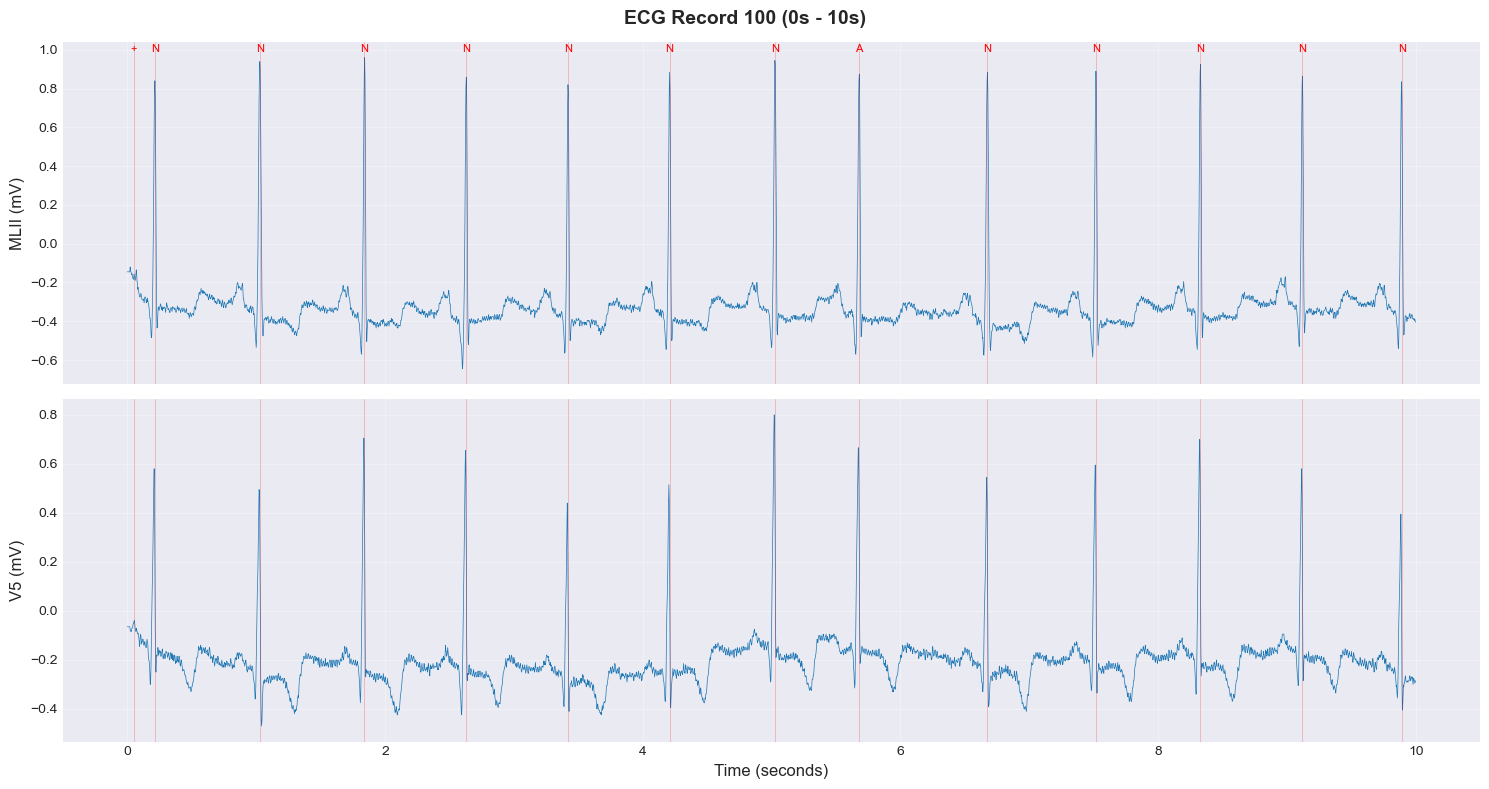

In [4]:
# Visualize 10 seconds of ECG
visualize_ecg(record_name, start_sec=0, duration_sec=10, show_annotations=True)


## 4. Beat Annotation Statistics


In [5]:
get_annotation_statistics(record_name)



Annotation Statistics for Record 100
Total beats: 2274

Beat type distribution:
  +:     1 ( 0.04%) - Unknown
  A:    33 ( 1.45%) - Atrial premature beat
  N:  2239 (98.46%) - Normal beat
  V:     1 ( 0.04%) - Premature ventricular contraction


## 5. Analyze All Records

Let's collect statistics from all records in the database.


In [6]:
# Collect statistics from all records
all_stats = []

for rec_name in records:
    try:
        record, annotation = load_ecg_record(rec_name)
        
        # Count beat types
        unique, counts = np.unique(annotation.symbol, return_counts=True)
        beat_counts = dict(zip(unique, counts))
        
        stats = {
            'record': rec_name,
            'total_beats': len(annotation.symbol),
            'duration_min': len(record.p_signal) / record.fs / 60,
            'normal_beats': beat_counts.get('N', 0),
            'abnormal_beats': len(annotation.symbol) - beat_counts.get('N', 0)
        }
        
        all_stats.append(stats)
    except Exception as e:
        print(f"Error processing {rec_name}: {e}")

# Create DataFrame
df_stats = pd.DataFrame(all_stats)
print(df_stats.head(15))

# Summary statistics
print("\n" + "="*60)
print("Dataset Summary:")
print("="*60)
print(f"Total records: {len(df_stats)}")
print(f"Total beats: {df_stats['total_beats'].sum():,}")
print(f"Total normal beats: {df_stats['normal_beats'].sum():,}")
print(f"Total abnormal beats: {df_stats['abnormal_beats'].sum():,}")
print(f"Abnormal beat percentage: {(df_stats['abnormal_beats'].sum() / df_stats['total_beats'].sum() * 100):.2f}%")
print(f"Average duration per record: {df_stats['duration_min'].mean():.2f} minutes")


   record  total_beats  duration_min  normal_beats  abnormal_beats
0     100         2274     30.092593          2239              35
1     101         1874     30.092593          1860              14
2     102         2192     30.092593            99            2093
3     103         2091     30.092593          2082               9
4     104         2311     30.092593           163            2148
5     105         2691     30.092593          2526             165
6     106         2098     30.092593          1507             591
7     107         2140     30.092593             0            2140
8     108         1824     30.092593          1739              85
9     109         2535     30.092593             0            2535
10    111         2133     30.092593             0            2133
11    112         2550     30.092593          2537              13
12    113         1796     30.092593          1789               7
13    114         1890     30.092593          1820            

## 6. Visualize Dataset Distribution


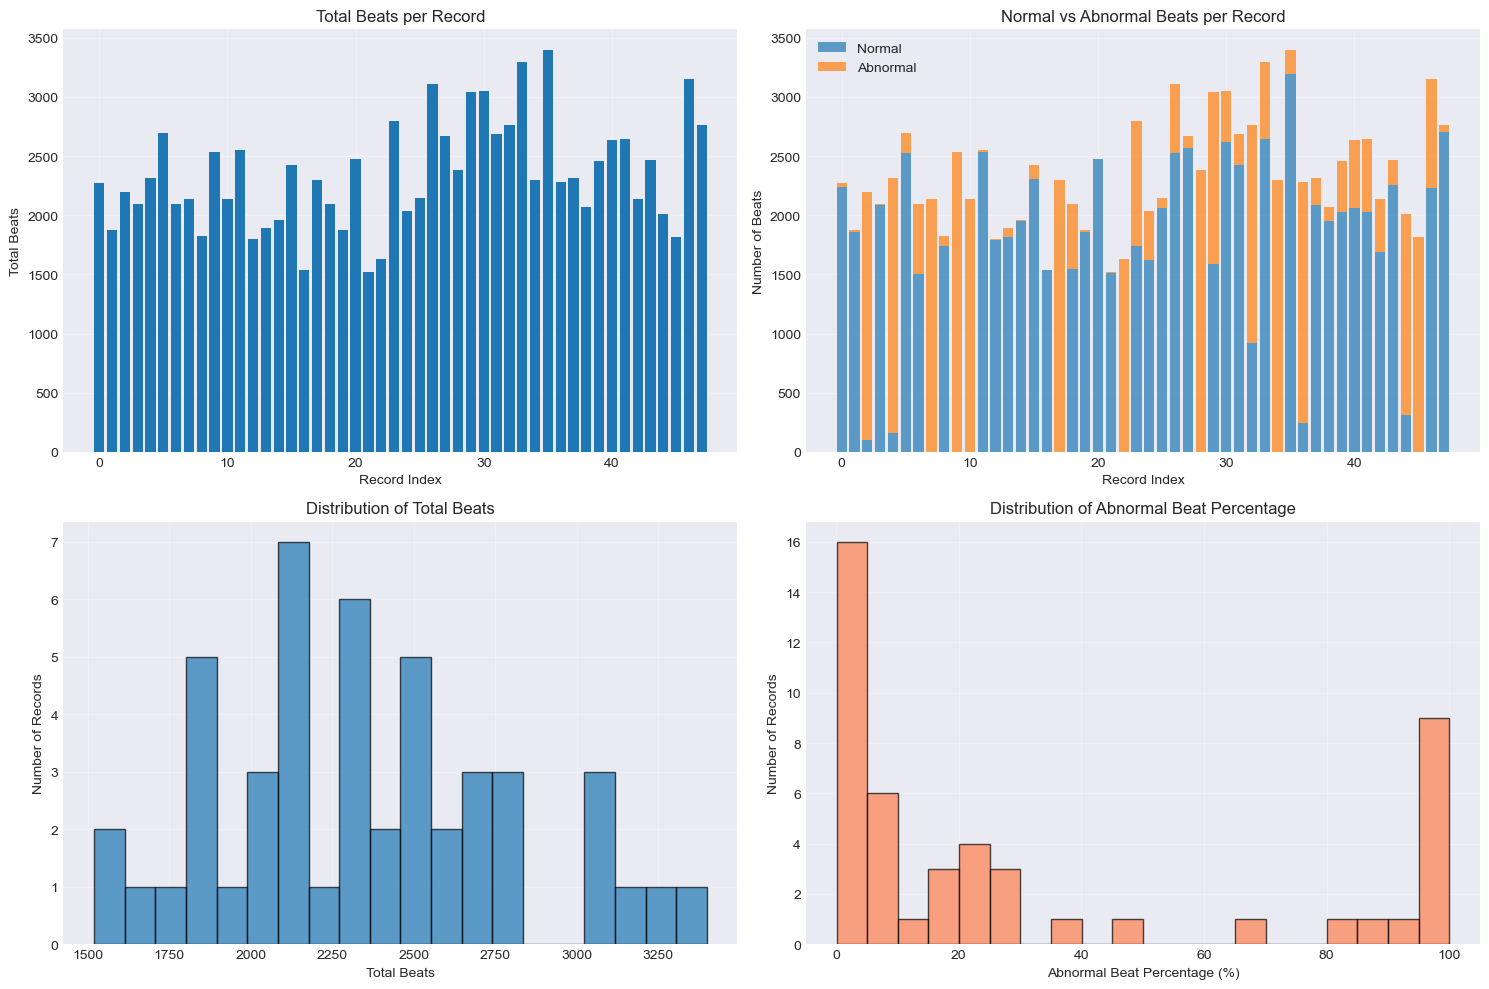

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Total beats per record
axes[0, 0].bar(range(len(df_stats)), df_stats['total_beats'])
axes[0, 0].set_xlabel('Record Index')
axes[0, 0].set_ylabel('Total Beats')
axes[0, 0].set_title('Total Beats per Record')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Normal vs Abnormal beats
axes[0, 1].bar(range(len(df_stats)), df_stats['normal_beats'], label='Normal', alpha=0.7)
axes[0, 1].bar(range(len(df_stats)), df_stats['abnormal_beats'], 
               bottom=df_stats['normal_beats'], label='Abnormal', alpha=0.7)
axes[0, 1].set_xlabel('Record Index')
axes[0, 1].set_ylabel('Number of Beats')
axes[0, 1].set_title('Normal vs Abnormal Beats per Record')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Distribution of total beats
axes[1, 0].hist(df_stats['total_beats'], bins=20, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Total Beats')
axes[1, 0].set_ylabel('Number of Records')
axes[1, 0].set_title('Distribution of Total Beats')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Abnormal beat percentage
df_stats['abnormal_pct'] = (df_stats['abnormal_beats'] / df_stats['total_beats']) * 100
axes[1, 1].hist(df_stats['abnormal_pct'], bins=20, edgecolor='black', color='coral', alpha=0.7)
axes[1, 1].set_xlabel('Abnormal Beat Percentage (%)')
axes[1, 1].set_ylabel('Number of Records')
axes[1, 1].set_title('Distribution of Abnormal Beat Percentage')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Next Steps

Now that you've explored the data, you can proceed with:
- Data Preprocessing
- Feature Extraction
- Build a Classifier
- Train and Evaluate
- Deploy
